Notes:
 * revised and tuned configuration, updated views
 * training on full dataset (including Y3, new light curves, fixes)
 * trained with updated star radius estimations, multiple duplicates removed
 * removed instar examples

In [3]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/ext_35_run_1'
data_files = '/mnt/tess/astronet/tfrecords-35-train/*'
tces_file = '/mnt/tess/astronet/tces-v12-train.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/ext_35_run_1/1/AstroCNNModel_extended_20220328_165807',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/2/AstroCNNModel_extended_20220328_173327',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/3/AstroCNNModel_extended_20220328_180751',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/4/AstroCNNModel_extended_20220328_184213',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/5/AstroCNNModel_extended_20220328_191617',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/6/AstroCNNModel_extended_20220328_194914',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/7/AstroCNNModel_extended_20220328_202225',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/8/AstroCNNModel_extended_20220328_205525',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/9/AstroCNNModel_extended_20220328_212823',
 '/mnt/tess/astronet/checkpoints/ext_35_run_1/10/AstroCNNModel_extended_20220328_220115']

In [4]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
19698 records
Running model 2
19698 records
Running model 3
19698 records
Running model 4
19698 records
Running model 5
19698 records
Running model 6
19698 records
Running model 7
19698 records
Running model 8
19698 records
Running model 9
19698 records
Running model 10
19698 records


In [5]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.2

In [6]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [7]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [8]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [9]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9956772334293948
Precision: 0.7960829493087558


In [10]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

387829772
369860950
379464439
381366555
761960972
49799681
294092966
176582931
152539284


In [11]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

384490098
384608233
387060242
389363745
389576843
389668544
390561536
391745260
391811200
391821647
392793407
394233079
394284999
394345045
394358240
394372611
396957480
298896016
252809234
29020857
292464126
322060802
326919774
332051907
333064504
348518919
9061195
165689608
193948281
199572752
235562906
236896126
236897301
259879138
343463316
417057112
418749263
430689771
455588711
455698002
468488829
173710176
18252911
186302615
252546286
252733538
252778660
25823018
25918053
26821153
336799587
148963635
154006988
156458268
156993882
165428216
18919598
198536950
388906923
101654574
101821550
112716272
112830723
119088593
119384992
119433341
120401906
128800217
128846212
128882149
140688564
140691839
141096229
141545493
141610473
423238309
425083216
425083264
431380283
441221559
446348045
451540413
451568159
453100472
456516439
456588598
456611584
464488581
466098380
467902598
468216079
469269031
49449799
50308490
369834384
369864019
369932580
370101492
370134610
370227480
373522149


In [24]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 150104471)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,
150104471,0.061691,0.273432,0.896241,0.004004,0.042941
150104471,0.024685,0.264496,0.931150,0.021045,0.039660
150104471,0.181032,0.354968,0.675627,0.009032,0.028122
150104471,0.431361,0.279017,0.447954,0.013327,0.013390
150104471,0.098898,0.383983,0.819418,0.005780,0.041152
150104471,0.094811,0.305148,0.791707,0.024258,0.139891
150104471,0.081163,0.414341,0.799552,0.012373,0.036905
150104471,0.098791,0.272337,0.807104,0.014567,0.020798
150104471,0.114436,0.395542,0.731846,0.026271,0.020404


In [13]:
pl[pl.index == 340066802]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,


### PR curve

In [14]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [15]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9879998795582506, max R: 1.0, max P: 1.0
100% recall at: 27%, threshold: 0.0034616146088192194


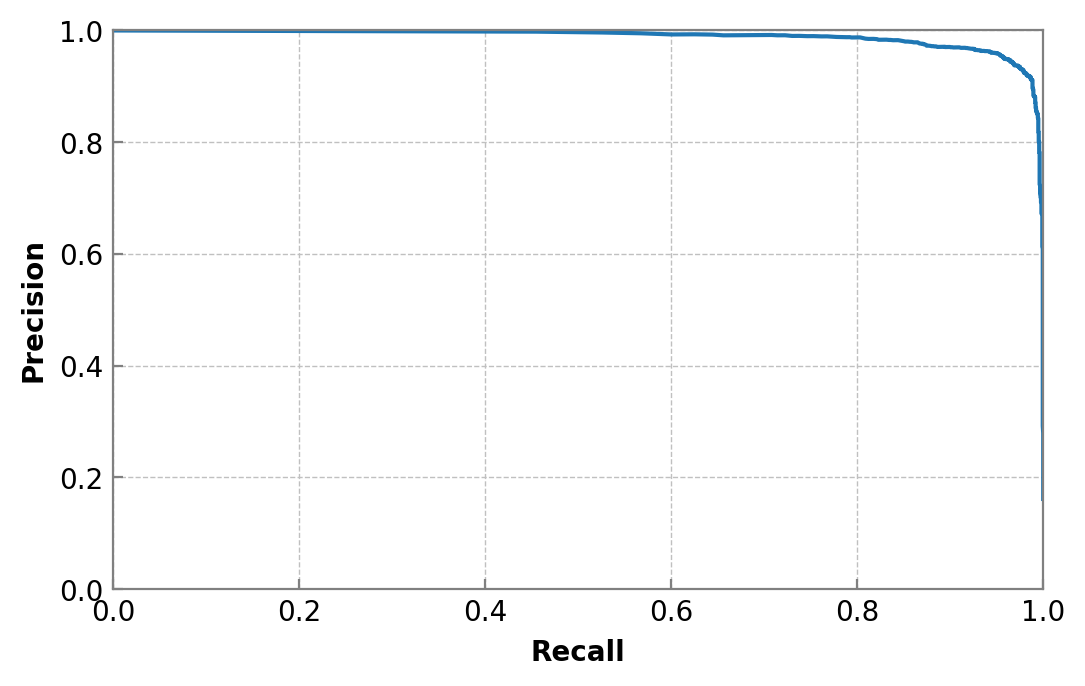

In [16]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)